# DAT257x: Reinforcement Learning Explained

## Lab 7: Policy Gradient

### Exercise 7.2: Baselined REINFORCE

This assignment features the Cartpole domain which tasks the agent with balancing a pole affixed to a movable cart. The agent employs two discrete actions which apply force to the cart. Episodes provide +1 reward for each step in which the pole has not fallen over, up to a maximum of 200 steps. 

## Objectives
* Implement a baselined version of REINFORCE
* Define a Value function network $V_\phi(s)$
* Build the trainer and associated loss function
* Train REINFORCE using baselined rewards  $\nabla_\theta J(\theta)=\sum_{t=0}^T \nabla_\theta \log \pi_\theta(a_t|s_t) (R - V_\phi(s_t))$

## Success Criterion
The main difference in a correct implementation of baselined REINFORCE will be a reduction in the variance. If correct, the baselined REINFORCE will achieve successful trials (of 200 steps) with a variance of less than 1000 on average, whereas the original REINFORCE was close to 2500.

Baselined REINFORCE should still solve the Cartpole domain about as often as before, but now with a lower variance.

In [1]:
import cntk as C
from cntk.layers import Sequential, Dense
from cntk.logging import ProgressPrinter
import numpy as np
import gym

import sys
if "../" not in sys.path:
    sys.path.append("../") 
    
from lib.running_variance import RunningVariance
from itertools import count
import sys

from lib import plotting

np.random.seed(123)
C.cntk_py.set_fixed_random_seed(123)
C.cntk_py.force_deterministic_algorithms()

env = gym.make('CartPole-v0')

state_dim = env.observation_space.shape[0] # Dimension of state space
action_count = env.action_space.n # Number of actions
hidden_size = 128 # Number of hidden units
update_frequency = 20

# The policy network maps an observation to a probability of taking action 0 or 1.
observations = C.sequence.input_variable(state_dim, np.float32, name="obs")
W1 = C.parameter(shape=(state_dim, hidden_size), init=C.glorot_uniform(), name="W1")
b1 = C.parameter(shape=hidden_size, name="b1")
layer1 = C.relu(C.times(observations, W1) + b1)
W2 = C.parameter(shape=(hidden_size, action_count), init=C.glorot_uniform(), name="W2")
b2 = C.parameter(shape=action_count, name="b2")
layer2 = C.times(layer1, W2) + b2
output = C.sigmoid(layer2, name="output")

# Label will tell the network what action it should have taken.
label = C.sequence.input_variable(1, np.float32, name="label")
# return_weight is a scalar containing the discounted return. It will scale the PG loss.
return_weight = C.sequence.input_variable(1, np.float32, name="weight")
# PG Loss 
loss = -C.reduce_mean(C.log(C.square(label - output) + 1e-4) * return_weight, axis=0, name='loss')

# Build the optimizer
lr_schedule = C.learning_rate_schedule(lr=0.1, unit=C.UnitType.sample) 
m_schedule = C.momentum_schedule(0.99)
vm_schedule = C.momentum_schedule(0.999)
optimizer = C.adam([W1, W2], lr_schedule, momentum=m_schedule, variance_momentum=vm_schedule)

# Create a buffer to manually accumulate gradients
gradBuffer = dict((var.name, np.zeros(shape=var.shape)) for var in loss.parameters if var.name in ['W1', 'W2', 'b1', 'b2'])

def discount_rewards(r, gamma=0.999):
    """Take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, r.size)):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


Now we need to define a critic network which will estimate the value function $V_\phi(s_t)$. You can likely reuse code from the policy network or look at other CNTK network examples.

Additionally, you'll need to define a squared error loss function, optimizer, and trainer for this newtork.

In [3]:
# TODO 1: Define the critic network that learns the value function V(s).
# Hint: you can use a similar architecture as the policy network, except
# the output should just be a scalar value estimate. Also, since the value
# function learning is more standard, it's possible to use stanard CNTK
# wrappers such as Trainer(). 

critic_input = 128
critic_output = 1

critic = Sequential([
    Dense(critic_input, activation=C.relu, init=C.glorot_uniform()),
    Dense(critic_output, activation=None, init=C.glorot_uniform(scale=.01))
])(observations)

# TODO 2: Define target and Squared Error Loss Function, adam optimizier, and trainer for the Critic.
critic_target = C.sequence.input_variable(1, np.float32, name="target") # Modify this
critic_loss = C.squared_error(critic, critic_target) # Modify this
critic_lr_schedule = C.learning_rate_schedule(lr=0.1, unit=C.UnitType.sample) 
critic_optimizer = C.adam(critic.parameters, critic_lr_schedule, momentum=m_schedule, variance_momentum=vm_schedule)
critic_trainer = C.Trainer(critic, (critic_loss, None), critic_optimizer)

The main training loop is nearly identical except you'll need to train the critic to minimize the difference between the predicted and observed return at each step. Additionally, you'll need to update the Reinforce update to subtract the baseline.

In [4]:
running_variance = RunningVariance()
reward_sum = 0

max_number_of_episodes = 500

stats = plotting.EpisodeStats(
    episode_lengths=np.zeros(max_number_of_episodes),
    episode_rewards=np.zeros(max_number_of_episodes),
    episode_running_variance=np.zeros(max_number_of_episodes))


for episode_number in range(max_number_of_episodes):
    states, rewards, labels = [],[],[]
    done = False
    observation = env.reset()
    t = 1
    while not done:
        state = np.reshape(observation, [1, state_dim]).astype(np.float32)
        states.append(state)

        # Run the policy network and get an action to take.
        prob = output.eval(arguments={observations: state})[0][0][0]
        # Sample from the bernoulli output distribution to get a discrete action
        action = 1 if np.random.uniform() < prob else 0

        # Pseudo labels to encourage the network to increase
        # the probability of the chosen action. This label will be used
        # in the loss function above.
        y = 1 if action == 0 else 0  # a "fake label"
        labels.append(y)

        # step the environment and get new measurements
        observation, reward, done, _ = env.step(action)
        reward_sum += float(reward)

        # Record reward (has to be done after we call step() to get reward for previous action)
        rewards.append(float(reward))
        
        stats.episode_rewards[episode_number] += reward
        stats.episode_lengths[episode_number] = t
        t += 1

    # Stack together all inputs, hidden states, action gradients, and rewards for this episode
    epx = np.vstack(states)
    epl = np.vstack(labels).astype(np.float32)
    epr = np.vstack(rewards).astype(np.float32)

    # Compute the discounted reward backwards through time.
    discounted_epr = discount_rewards(epr)

    # TODO 3
    # Train the critic to predict the discounted reward from the observation
    # - use train_minibatch() function of the critic_trainer. 
    # - observations is epx which are the states, and critic_target is discounted_epr
    # - then predict the discounted reward using the eval() function of the critic network and assign it to baseline
    critic_trainer.train_minibatch({observations: epx, critic_target: discounted_epr}) # modify this
    baseline = critic.eval({observations: epx}) # modify this
    
    # Compute the baselined returns: A = R - b(s). Weight the gradients by this value.
    baselined_returns = discounted_epr - baseline
    
    # Keep a running estimate over the variance of the discounted rewards (in this case baselined_returns)
    for r in baselined_returns:
        running_variance.add(r[0])

    # Forward pass
    arguments = {observations: epx, label: epl, return_weight: baselined_returns}
    state, outputs_map = loss.forward(arguments, outputs=loss.outputs,
                                      keep_for_backward=loss.outputs)

    # Backward pass
    root_gradients = {v: np.ones_like(o) for v, o in outputs_map.items()}
    vargrads_map = loss.backward(state, root_gradients, variables=set([W1, W2]))

    for var, grad in vargrads_map.items():
        gradBuffer[var.name] += grad

    # Only update every 20 episodes to reduce noise
    if episode_number % update_frequency == 0:
        grads = {W1: gradBuffer['W1'].astype(np.float32),
                 W2: gradBuffer['W2'].astype(np.float32)}
        updated = optimizer.update(grads, update_frequency)

        # reset the gradBuffer
        gradBuffer = dict((var.name, np.zeros(shape=var.shape))
                          for var in loss.parameters if var.name in ['W1', 'W2', 'b1', 'b2'])

        print('Episode: %d/%d. Average reward for episode %f. Variance %f' % (episode_number, max_number_of_episodes, reward_sum / update_frequency, running_variance.get_variance()))
            
        sys.stdout.flush()
        
        reward_sum = 0
        
    stats.episode_running_variance[episode_number] = running_variance.get_variance()

Episode: 0/500. Average reward for episode 1.800000. Variance -0.000000


../lib/running_variance.py:21: RuntimeWarning: invalid value encountered in true_divide
  return self.s_k / (self.k - 1)


Episode: 20/500. Average reward for episode 43.300000. Variance 418.853180
Episode: 40/500. Average reward for episode 69.050000. Variance 860.875000
Episode: 60/500. Average reward for episode 102.100000. Variance 891.215393
Episode: 80/500. Average reward for episode 152.900000. Variance 1205.820923
Episode: 100/500. Average reward for episode 130.700000. Variance 1336.119263
Episode: 120/500. Average reward for episode 125.450000. Variance 1383.987305
Episode: 140/500. Average reward for episode 104.650000. Variance 1314.198242
Episode: 160/500. Average reward for episode 109.400000. Variance 1327.395874
Episode: 180/500. Average reward for episode 86.450000. Variance 1311.660767
Episode: 200/500. Average reward for episode 93.150000. Variance 1335.135376
Episode: 220/500. Average reward for episode 84.400000. Variance 1327.412109
Episode: 240/500. Average reward for episode 89.600000. Variance 1318.831299
Episode: 260/500. Average reward for episode 84.800000. Variance 1327.407715


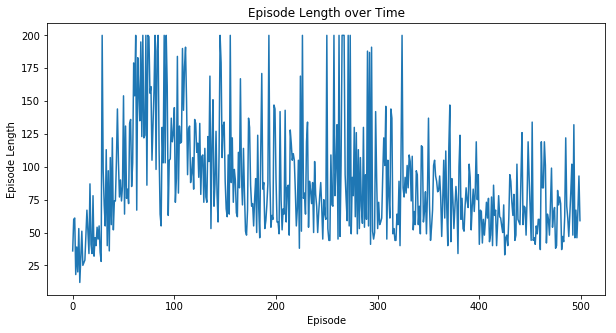

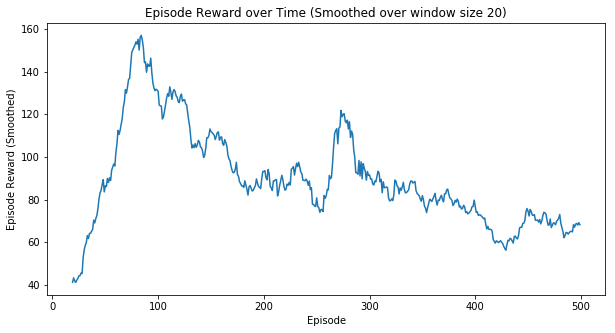

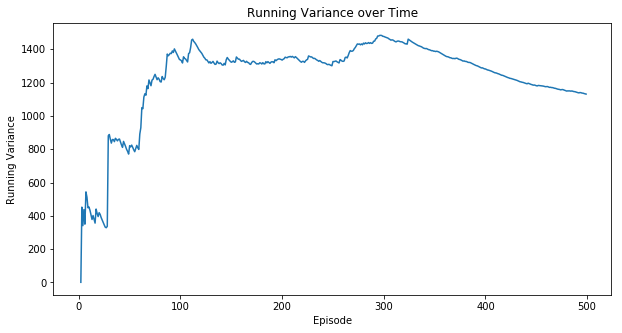

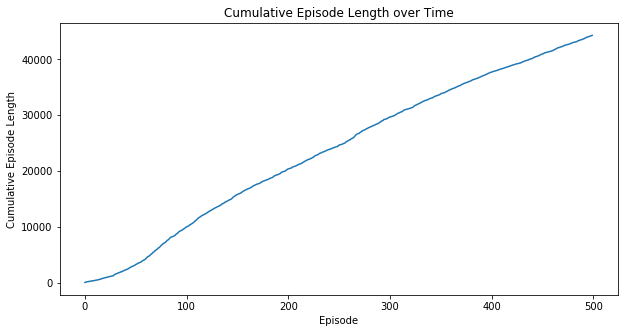

(<matplotlib.figure.Figure at 0x7f10e67687f0>,
 <matplotlib.figure.Figure at 0x7f10e66552e8>)

In [5]:
plotting.plot_pgresults(stats)